<a href="https://colab.research.google.com/github/nfonteyne/Audio_Sample_Listenable/blob/main/data_fusion_MelSpec_MFCC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi input model : tabular data & image data

#Utilisation du Mel Spectrogramme dans un réseau de neuronne en vu d'observer les résulats de ce type de modèle

Je replace ici les lien allant dans le sens de l'utilisation de ce modèle : 

*   **Audio Recognition using Mel Spectrograms and Convolution Neural Networks** ==> http://noiselab.ucsd.edu/ECE228_2019/Reports/Report38.pdf
*   **Audio Deep Learning Made Simple (Part 2): Why Mel Spectrograms perform better** ==> https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
* **Cough Recognition Based on Mel-Spectrogram and Convolutional Neural Network** ==> https://www.frontiersin.org/articles/10.3389/frobt.2021.580080/full


**Ainsi qu'une explication sur ce qu'est l'echelle de Mel :**

L'échelle de Mel est une échelle de fréquences basée sur la perception humaine. Elle se mesure en mels.

**Principe :**

Elle a été conçue de telle façon que 1000Hz correspondent à 1000mels et qu'une variation constante dans le domaine des mels soit perçue comme une variation constante de fréquence (en Hz) par les auditeurs.
 
En effet, au-delà de 500Hz, l'oreille humaine ne perçoit plus le changement d'octave comme un doublement de la fréquence. Par contre, si on se place sur une échelle de Mel, un changement d'octave sera effectivement perçu comme un doublement de la fréquence.


✋
(si vous avez besoin d'informations supplémentaires concernant librosa, je vous invite à regarder mon autre notebook "Information Librosa" ou a chercher directement sur la docu de la librairie.)

✋ faites une copie du notebook dans votre drive si vous voulez tester le modèle et faire des modifs



### Importation des bibliothèques utiles

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob
#Le module glob recherche tous les chemins correspondant à un motif 
#particulier selon les règles utilisées par le shell Unix, les résultats sont renvoyés dans un ordre arbitraire.

import librosa
import librosa.display
import IPython.display as ipd

from tqdm import tqdm
import os

### Visualisation du spectrogramme

✋Vous aurez besoin de charger les echantillons audios des 3 premiers fichier 00000, 00001,00002 dans votre repertoire courant si vous voulez relancer l'entrainement des modèles.

In [ ]:
audio_files = glob('data_5/*.wav')

In [ ]:
audio_files

['data_5\\000000.wav',
 'data_5\\000057.wav',
 'data_5\\000094.wav',
 'data_5\\000110.wav',
 'data_5\\000135.wav',
 'data_5\\000147.wav',
 'data_5\\000189.wav',
 'data_5\\000249.wav',
 'data_5\\000273.wav',
 'data_5\\000286.wav',
 'data_5\\000302.wav',
 'data_5\\000310.wav',
 'data_5\\000440.wav',
 'data_5\\000476.wav',
 'data_5\\000521.wav',
 'data_5\\000607.wav',
 'data_5\\000700.wav',
 'data_5\\000702.wav',
 'data_5\\000765.wav',
 'data_5\\000795.wav',
 'data_5\\000831.wav',
 'data_5\\000858.wav',
 'data_5\\000884.wav',
 'data_5\\000910.wav',
 'data_5\\000938.wav',
 'data_5\\000975.wav',
 'data_5\\001056.wav',
 'data_5\\001074.wav',
 'data_5\\001078.wav',
 'data_5\\001198.wav',
 'data_5\\001274.wav',
 'data_5\\001287.wav',
 'data_5\\001311.wav',
 'data_5\\001326.wav',
 'data_5\\001335.wav',
 'data_5\\001381.wav',
 'data_5\\001382.wav',
 'data_5\\001404.wav',
 'data_5\\001449.wav',
 'data_5\\001458.wav',
 'data_5\\001476.wav',
 'data_5\\001532.wav',
 'data_5\\001558.wav',
 'data_5\\0

In [ ]:
y, sr = librosa.load(audio_files[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-7.5550832e-07  1.0226838e-06 -1.2791763e-06  1.5029752e-06
 -1.6730863e-06  1.7749246e-06 -1.8128379e-06  1.8518842e-06
 -2.2444847e-06  6.9662669e-06]
shape y: (22528,)
sr: 22050


In [ ]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

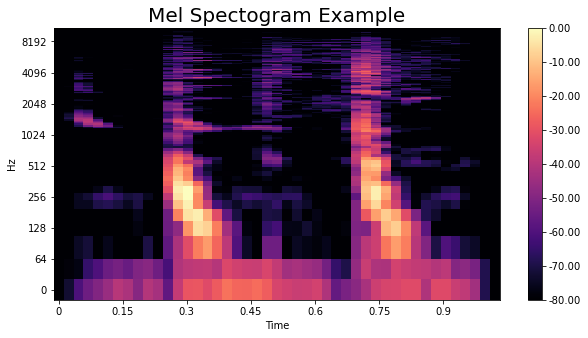

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

### Création du mel spectrogram pour tous les fichiers audios du répertoire

* :Aide pour créer le modèle ==> https://www.kaggle.com/code/nilshmeier/melspectrogram-based-cnn-classification

In [ ]:
feature_list = []
label_list = []
dictMel = {}
# On utiliser une boucle for qui va passer par tous les fichiers de notre répertoire
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir('./data_5/')): #on précise notre répertoire

    if not file.endswith('.wav'):#condition pour prendre seulement les .wav
        continue

    audio_path = os.path.join('data_5/', file)
    audio, sr = librosa.load(path=audio_path, sr=None) # load audio files
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr) #met le son sur 1s

    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0) #Convert a power spectrogram (amplitude squared) to decibel (dB) units
    # filename = int(str(file)[2:-4])
    filename = str(file)
    feature_list.append(mels_db)
    # label_list.append(int(str(file)[2:-4]))
    label_list.append(str(file))
    dictMel[filename] = mels_db


Preparing feature dataset and labels.


 34%|███▍      | 170/500 [00:20<00:21, 15.66it/s]c:\Users\azeqs\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2000
  return f(*args, **kwargs)
 96%|█████████▌| 479/500 [00:41<00:01, 16.05it/s]c:\Users\azeqs\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1000
  return f(*args, **kwargs)
100%|██████████| 500/500 [00:43<00:00, 11.62it/s]


In [ ]:
feature_list[0].shape

(128, 87)

In [ ]:
# features = np.array(feature_list)
labels = np.array(label_list)

In [ ]:
len(feature_list)

500

In [ ]:
len(label_list)

500

### Visualisation d'un élément

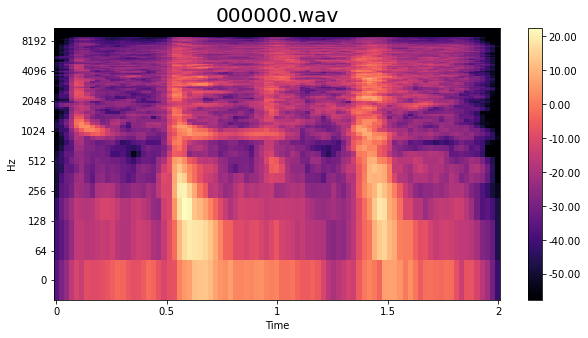

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(feature_list[0],
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title(label_list[0], fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

### On remarque un problème avec les éléments. En effet ceux-ci ne sont pas ordonnés dans le même ordre que celui qui est dans le colab

In [ ]:
dataMel = pd.Series(dictMel)

In [ ]:
dictMel

{'000000.wav': array([[-35.945404, -28.567726, -23.93756 , ..., -21.56263 , -30.527193,
         -41.928555],
        [-38.7615  , -34.9017  , -29.994009, ..., -29.524534, -32.865616,
         -47.086433],
        [-42.365654, -32.028423, -26.664871, ..., -35.22728 , -39.07948 ,
         -47.81404 ],
        ...,
        [-57.506905, -57.506905, -57.506905, ..., -57.506905, -57.506905,
         -57.506905],
        [-57.506905, -57.506905, -57.506905, ..., -57.506905, -57.506905,
         -57.506905],
        [-57.506905, -57.506905, -57.506905, ..., -57.506905, -57.506905,
         -57.506905]], dtype=float32),
 '000057.wav': array([[-39.32493  , -32.552307 , -33.73304  , ..., -32.149372 ,
         -42.284283 , -48.304993 ],
        [-18.751295 , -13.878231 , -10.626921 , ..., -19.85523  ,
         -27.72629  , -41.20256  ],
        [-11.569279 ,  -2.0273054,   3.232006 , ...,  -8.740222 ,
         -19.878551 , -32.91222  ],
        ...,
        [-56.039177 , -56.039177 , -56.039177 ,

In [ ]:
dataMel

000000.wav    [[-35.945404, -28.567726, -23.93756, -15.65245...
000057.wav    [[-39.32493, -32.552307, -33.73304, -28.731022...
000094.wav    [[-53.563652, -47.604298, -46.997665, -49.6144...
000110.wav    [[-32.369747, -33.298042, -33.1114, -24.833542...
000135.wav    [[-15.156305, -10.304679, -12.558703, -13.3486...
                                    ...                        
022531.wav    [[-18.323744, -13.015215, -5.5253677, -4.19523...
022662.wav    [[-14.434524, -4.1330976, 9.450955, 15.939758,...
022718.wav    [[-54.956093, -47.669533, -53.707424, -60.6013...
022869.wav    [[-16.327732, -6.2766547, -8.176809, -8.734543...
022914.wav    [[-20.68304, -15.640064, -14.393679, -8.161341...
Length: 500, dtype: object

In [ ]:
dataMel=dataMel.sort_index()

In [ ]:
dataMel

000000.wav    [[-35.945404, -28.567726, -23.93756, -15.65245...
000057.wav    [[-39.32493, -32.552307, -33.73304, -28.731022...
000094.wav    [[-53.563652, -47.604298, -46.997665, -49.6144...
000110.wav    [[-32.369747, -33.298042, -33.1114, -24.833542...
000135.wav    [[-15.156305, -10.304679, -12.558703, -13.3486...
                                    ...                        
022531.wav    [[-18.323744, -13.015215, -5.5253677, -4.19523...
022662.wav    [[-14.434524, -4.1330976, 9.450955, 15.939758,...
022718.wav    [[-54.956093, -47.669533, -53.707424, -60.6013...
022869.wav    [[-16.327732, -6.2766547, -8.176809, -8.734543...
022914.wav    [[-20.68304, -15.640064, -14.393679, -8.161341...
Length: 500, dtype: object

In [ ]:
dfMel = dataMel.to_frame()
dfMel['filename'] = dfMel.index
dfMel=dfMel.reset_index()
dfMel.drop("index", axis = 1, inplace = True)
dfMel.rename(columns={0: "mel_features"}, inplace = True)
dfMel

,mel_features,filename
0,"[[-35.945404, -28.567726, -23.93756, -15.65245...",000000.wav
1,"[[-39.32493, -32.552307, -33.73304, -28.731022...",000057.wav
2,"[[-53.563652, -47.604298, -46.997665, -49.6144...",000094.wav
3,"[[-32.369747, -33.298042, -33.1114, -24.833542...",000110.wav
4,"[[-15.156305, -10.304679, -12.558703, -13.3486...",000135.wav
...,...,...
495,"[[-18.323744, -13.015215, -5.5253677, -4.19523...",022531.wav
496,"[[-14.434524, -4.1330976, 9.450955, 15.939758,...",022662.wav
497,"[[-54.956093, -47.669533, -53.707424, -60.6013...",022718.wav
498,"[[-16.327732, -6.2766547, -8.176809, -8.734543...",022869.wav


In [ ]:
listMel =dataMel.to_list()

In [ ]:
listMel

[array([[-35.945404, -28.567726, -23.93756 , ..., -21.56263 , -30.527193,
         -41.928555],
        [-38.7615  , -34.9017  , -29.994009, ..., -29.524534, -32.865616,
         -47.086433],
        [-42.365654, -32.028423, -26.664871, ..., -35.22728 , -39.07948 ,
         -47.81404 ],
        ...,
        [-57.506905, -57.506905, -57.506905, ..., -57.506905, -57.506905,
         -57.506905],
        [-57.506905, -57.506905, -57.506905, ..., -57.506905, -57.506905,
         -57.506905],
        [-57.506905, -57.506905, -57.506905, ..., -57.506905, -57.506905,
         -57.506905]], dtype=float32),
 array([[-39.32493  , -32.552307 , -33.73304  , ..., -32.149372 ,
         -42.284283 , -48.304993 ],
        [-18.751295 , -13.878231 , -10.626921 , ..., -19.85523  ,
         -27.72629  , -41.20256  ],
        [-11.569279 ,  -2.0273054,   3.232006 , ...,  -8.740222 ,
         -19.878551 , -32.91222  ],
        ...,
        [-56.039177 , -56.039177 , -56.039177 , ..., -56.039177 ,
         

In [ ]:
datacomp = pd.read_csv("Sample5_label_mediane_.csv")  # lecture du fichier contenant les notes de chaque samples audio
datacomp

,filename,mediane,bool_audible
0,000000.wav,3,1
1,000057.wav,2,0
2,000094.wav,4,1
3,000110.wav,3,1
4,000135.wav,4,1
...,...,...,...
495,022531.wav,2,0
496,022662.wav,4,1
497,022718.wav,2,0
498,022869.wav,3,1


In [ ]:
dfMel = dfMel.merge(datacomp, how='left', on='filename')  # on merge ensuite les données mfcc de chaque sample à leurs notes (mediane + booléen)
dfMel

,mel_features,filename,mediane,bool_audible
0,"[[-35.945404, -28.567726, -23.93756, -15.65245...",000000.wav,3,1
1,"[[-39.32493, -32.552307, -33.73304, -28.731022...",000057.wav,2,0
2,"[[-53.563652, -47.604298, -46.997665, -49.6144...",000094.wav,4,1
3,"[[-32.369747, -33.298042, -33.1114, -24.833542...",000110.wav,3,1
4,"[[-15.156305, -10.304679, -12.558703, -13.3486...",000135.wav,4,1
...,...,...,...,...
495,"[[-18.323744, -13.015215, -5.5253677, -4.19523...",022531.wav,2,0
496,"[[-14.434524, -4.1330976, 9.450955, 15.939758,...",022662.wav,4,1
497,"[[-54.956093, -47.669533, -53.707424, -60.6013...",022718.wav,2,0
498,"[[-16.327732, -6.2766547, -8.176809, -8.734543...",022869.wav,3,1


### Une fois le tri effectué, On doit convertir notre liste de matrice 2D en matrice 3d pour utiliser notre réseau de neuronne.

In [ ]:
def list_to_matrix(X):
  matrix = np.zeros(shape=(len(X),128, 87))
  for i in range(len(X)):
    if X[i].shape == (128, 87):
      # print(X[i].shape, ' son num : ',i)
      matrix[i]=X[i]
  return matrix

In [ ]:
matrix = list_to_matrix(dfMel['mel_features'].to_list())

In [ ]:
np.amin(matrix)

-100.0

In [ ]:
matrix=np.interp(matrix,(-65,35),(0,1))

In [ ]:
matrix.shape

(500, 128, 87)

In [ ]:
matrix

array([[[0.29054596, 0.36432274, 0.41062441, ..., 0.4343737 ,
         0.34472807, 0.23071445],
        [0.26238499, 0.30098301, 0.35005991, ..., 0.35475466,
         0.32134384, 0.17913567],
        [0.22634346, 0.32971577, 0.38335129, ..., 0.2977272 ,
         0.25920521, 0.17185959],
        ...,
        [0.07493095, 0.07493095, 0.07493095, ..., 0.07493095,
         0.07493095, 0.07493095],
        [0.07493095, 0.07493095, 0.07493095, ..., 0.07493095,
         0.07493095, 0.07493095],
        [0.07493095, 0.07493095, 0.07493095, ..., 0.07493095,
         0.07493095, 0.07493095]],

       [[0.25675072, 0.32447693, 0.3126696 , ..., 0.32850628,
         0.22715717, 0.16695007],
        [0.46248705, 0.51121769, 0.54373079, ..., 0.4514477 ,
         0.3727371 , 0.2379744 ],
        [0.53430721, 0.62972695, 0.68232006, ..., 0.56259778,
         0.45121449, 0.3208778 ],
        ...,
        [0.08960823, 0.08960823, 0.08960823, ..., 0.08960823,
         0.08960823, 0.08960823],
        [0.0

###Récupération des labels

<AxesSubplot:>

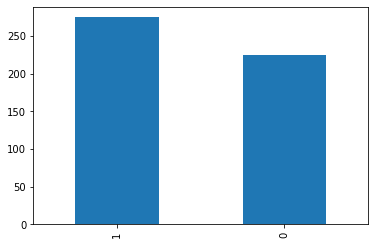

In [ ]:
datacomp['bool_audible'].value_counts().plot(kind='bar')

In [ ]:
datacomp.bool_audible.unique()

array([1, 0], dtype=int64)

In [ ]:
datacomp.bool_audible.value_counts()
#on observe déja un déséquilibre dans les classes

1    275
0    225
Name: bool_audible, dtype: int64

### Préparation des données pour le réseau de neuronnes

In [ ]:
X_train_full = matrix.reshape(-1, 128, 87, 1)
y_train_full = dfMel[['bool_audible']]
#on peut changer la métrique de notre label en choisissant La moyenne ou la médiane
#y_train_full = datacomp[['Moyenne']]

In [ ]:
X_train, y_train = X_train_full[:400],y_train_full[:400]  # slicing à modifier en fonction du nombre de samples
X_test, y_test = X_train_full[400:],y_train_full[400:]
#on split nos données en train et test set

In [ ]:
print(X_test.shape)
print(y_test.shape)

(100, 128, 87, 1)
(100, 1)


###Constuire un model avec tf.keras.sequential

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
mel_model = keras.models.Sequential()
mel_model.add(keras.layers.Flatten(input_shape=[128, 87]))
mel_model.add(keras.layers.Dense(1000, activation="relu"))
mel_model.add(keras.layers.Dense(300, activation="relu"))
mel_model.add(keras.layers.Dense(1, activation="sigmoid"))

mel_model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Autre model que l'on peut tester et qui peut etre interessant

* https://www.kaggle.com/code/nilshmeier/melspectrogram-based-cnn-classification

In [ ]:
# model = keras.Sequential(layers=[
#         keras.layers.InputLayer(input_shape=[128, 87]),
#         keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
#         keras.layers.MaxPooling2D(),
#         keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
#         keras.layers.MaxPooling2D(),
#         keras.layers.Flatten(),
#         keras.layers.Dropout(0.3),
#         keras.layers.Dense(64, activation=keras.activations.relu),
#         keras.layers.Dense(10, activation=keras.activations.softmax)
#     ])
# model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# print(model.summary())

In [ ]:
mel_model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=X_train_full[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(1, activation=keras.activations.sigmoid)
    ])
mel_model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
print(mel_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 87, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 43, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 43, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 21, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 21504)             0         
                                                                 
 dropout (Dropout)           (None, 21504)             0

In [ ]:
mel_model.optimizer.learning_rate = 0.01

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

In [ ]:
epochs = 100
history_mel = mel_model.fit(X_train_full, y_train_full, epochs=epochs, validation_split=0.1)

Epoch 1/100
15/15 [==============================] - 3s 83ms/step - loss: 79.0282 - accuracy: 0.5067 - val_loss: 4.7644 - val_accuracy: 0.5800
Epoch 2/100
15/15 [==============================] - 1s 66ms/step - loss: 3.1135 - accuracy: 0.5867 - val_loss: 0.7461 - val_accuracy: 0.5400
Epoch 3/100
15/15 [==============================] - 1s 72ms/step - loss: 0.7016 - accuracy: 0.5711 - val_loss: 0.6743 - val_accuracy: 0.4600
Epoch 4/100
15/15 [==============================] - 1s 74ms/step - loss: 0.6532 - accuracy: 0.6067 - val_loss: 0.7995 - val_accuracy: 0.4800
Epoch 5/100
15/15 [==============================] - 1s 74ms/step - loss: 0.6197 - accuracy: 0.6378 - val_loss: 0.6819 - val_accuracy: 0.5800
Epoch 6/100
15/15 [==============================] - 1s 91ms/step - loss: 0.5831 - accuracy: 0.6933 - val_loss: 0.7316 - val_accuracy: 0.6200
Epoch 7/100
15/15 [==============================] - 1s 70ms/step - loss: 0.5752 - accuracy: 0.6867 - val_loss: 0.7877 - val_accuracy: 0.4800
Epoch

###On trace les courbes d'apprentissage

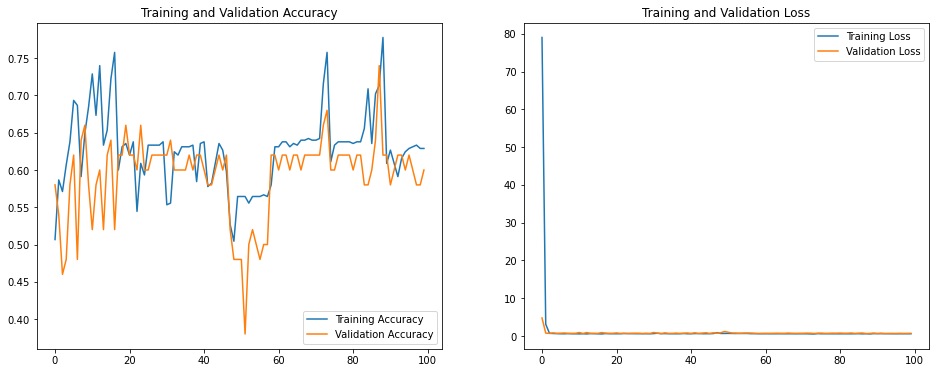

In [ ]:
acc = history_mel.history['accuracy']
val_acc = history_mel.history['val_accuracy']

loss = history_mel.history['loss']
val_loss = history_mel.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## MFCC as tabular data

In [ ]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Keras
import keras
from keras import models
from keras import layers

In [ ]:
import pandas as pd
data = pd.read_csv('mfcc_data.csv')  #on lie un fichier réportoriant les mfcc liés à chaque samples (cf. bibliothèque librosa)
data

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,000000.wav,0.603898,0.031367,2936.813245,2369.719529,5564.897461,0.157932,-254.100479,54.044090,-39.064354,...,-1.902891,17.123833,-0.442962,13.544829,-5.722409,13.724339,-0.188671,15.794836,-2.672952,8.049076
1,000057.wav,0.422483,0.086721,2561.207680,2178.601260,4270.751953,0.186806,-222.468750,101.995377,32.036026,...,-5.806344,1.783189,-11.960257,5.547661,-9.501064,0.776168,-15.150716,3.725864,-11.559823,-4.230488
2,000094.wav,0.264417,0.103363,2619.874952,2538.804270,5294.664108,0.122366,-217.846786,67.470200,6.611508,...,-19.025352,4.317915,-22.375034,-0.118121,-22.907751,-9.526878,-13.131836,-10.969196,-15.940857,0.098106
3,000110.wav,0.350203,0.111887,2478.841237,2363.374512,4812.670898,0.142998,-174.426285,86.092651,11.410549,...,-15.549378,1.266244,-10.829142,2.732645,-3.486956,-0.496458,-22.508924,4.357522,-14.726767,-6.183827
4,000135.wav,0.059480,0.014058,177.059853,158.696381,346.704555,0.008981,-580.194885,16.645065,-8.016385,...,-0.564394,-0.869830,-0.966833,-0.215884,-1.618023,-0.430290,-0.981847,-0.755029,-0.455876,-0.124699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,013572.wav,0.426300,0.199821,1107.360216,1447.722740,2204.042969,0.034592,-225.211349,143.597610,-26.180300,...,1.734117,6.030549,5.036570,5.490144,5.644398,7.054774,3.630918,3.491907,1.657841,1.258962
295,013644.wav,0.614637,0.307136,2459.026670,2391.603874,5095.234375,0.108149,9.378615,86.197220,-23.024117,...,-1.986704,13.807947,-4.375595,5.818483,-7.097770,10.230428,-2.836406,7.786288,-5.815650,7.001493
296,013674.wav,0.356163,0.078390,2031.402451,2373.243839,4463.354492,0.066526,-218.707397,94.485397,-3.933432,...,-1.489035,-6.836205,-10.823569,2.170913,-9.249109,3.917122,-9.068930,-4.000710,-4.877074,-5.016196
297,013755.wav,0.538265,0.141382,2640.387109,3021.159119,6619.957644,0.081543,-123.115974,85.551491,23.280281,...,-8.994740,16.527946,-6.626241,12.067850,-7.401072,8.214767,-8.611303,8.679101,-6.528778,6.956100


In [ ]:
labels = pd.read_csv("Sample_label.csv")  # de la manière que précédemment nous allons récupérer le csv répertoriant les notes données aux samples audio
labels

,filename,label
0,000000.wav,1
1,000057.wav,0
2,000094.wav,1
3,000110.wav,1
4,000135.wav,1
...,...,...
294,013572.wav,1
295,013644.wav,0
296,013674.wav,0
297,013755.wav,1


In [ ]:
labels.label.value_counts()

1    169
0    130
Name: label, dtype: int64

In [ ]:
data = data.merge(labels, how='left', on='filename')  # on merge ensuite les 2 tableaux
data

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,000000.wav,0.603898,0.031367,2936.813245,2369.719529,5564.897461,0.157932,-254.100479,54.044090,-39.064354,...,17.123833,-0.442962,13.544829,-5.722409,13.724339,-0.188671,15.794836,-2.672952,8.049076,1
1,000057.wav,0.422483,0.086721,2561.207680,2178.601260,4270.751953,0.186806,-222.468750,101.995377,32.036026,...,1.783189,-11.960257,5.547661,-9.501064,0.776168,-15.150716,3.725864,-11.559823,-4.230488,0
2,000094.wav,0.264417,0.103363,2619.874952,2538.804270,5294.664108,0.122366,-217.846786,67.470200,6.611508,...,4.317915,-22.375034,-0.118121,-22.907751,-9.526878,-13.131836,-10.969196,-15.940857,0.098106,1
3,000110.wav,0.350203,0.111887,2478.841237,2363.374512,4812.670898,0.142998,-174.426285,86.092651,11.410549,...,1.266244,-10.829142,2.732645,-3.486956,-0.496458,-22.508924,4.357522,-14.726767,-6.183827,1
4,000135.wav,0.059480,0.014058,177.059853,158.696381,346.704555,0.008981,-580.194885,16.645065,-8.016385,...,-0.869830,-0.966833,-0.215884,-1.618023,-0.430290,-0.981847,-0.755029,-0.455876,-0.124699,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,013572.wav,0.426300,0.199821,1107.360216,1447.722740,2204.042969,0.034592,-225.211349,143.597610,-26.180300,...,6.030549,5.036570,5.490144,5.644398,7.054774,3.630918,3.491907,1.657841,1.258962,1
295,013644.wav,0.614637,0.307136,2459.026670,2391.603874,5095.234375,0.108149,9.378615,86.197220,-23.024117,...,13.807947,-4.375595,5.818483,-7.097770,10.230428,-2.836406,7.786288,-5.815650,7.001493,0
296,013674.wav,0.356163,0.078390,2031.402451,2373.243839,4463.354492,0.066526,-218.707397,94.485397,-3.933432,...,-6.836205,-10.823569,2.170913,-9.249109,3.917122,-9.068930,-4.000710,-4.877074,-5.016196,0
297,013755.wav,0.538265,0.141382,2640.387109,3021.159119,6619.957644,0.081543,-123.115974,85.551491,23.280281,...,16.527946,-6.626241,12.067850,-7.401072,8.214767,-8.611303,8.679101,-6.528778,6.956100,1


## Maintant le pre-process terminé nous allons split notre dataset

In [ ]:
### Split the dataset into independent and dependent dataset
X=np.array(data.drop(["label", "filename"], axis=1))
y=np.array(data['label'].tolist())

### Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Text(0, 0.5, 'Percentage of classes')

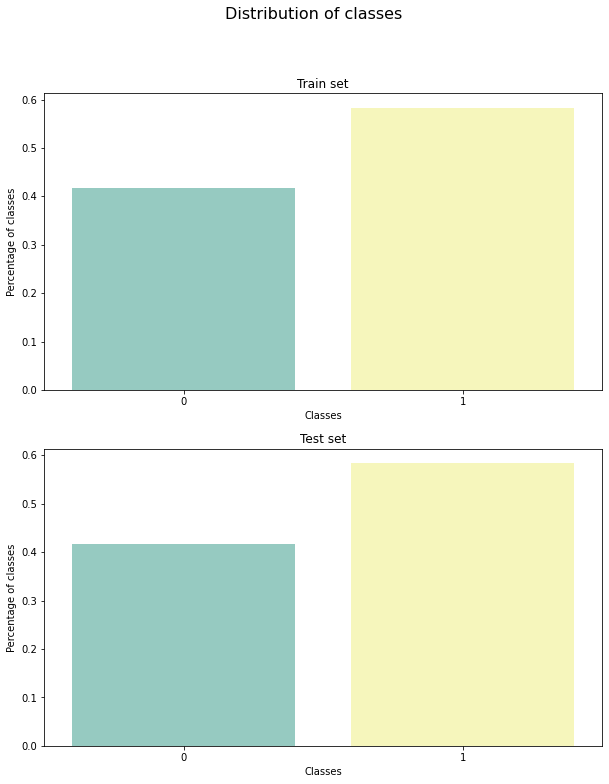

In [ ]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,12))
fig.suptitle("Distribution of classes", fontsize=16)

# compute the distribution for each set
train_ind, train_counts = np.unique(y_train, return_counts=True)
test_ind, test_counts = np.unique(y_test, return_counts=True)

train_label_percentage = train_counts / X_train.shape[0]
test_label_percentage = test_counts / X_test.shape[0]

# plot train
sns.barplot(ax=ax1, x=train_ind, y=test_label_percentage, palette="Set3")
ax1.set_title("Train set")
ax1.set_xlabel("Classes")
ax1.set_ylabel("Percentage of classes")

# plot test
sns.barplot(ax=ax2, x=test_ind, y=test_label_percentage, palette="Set3")
ax2.set_title("Test set")
ax2.set_xlabel("Classes")
ax2.set_ylabel("Percentage of classes")

Le dataset n'est pas bien distribué --> 20% entre chaque classes dans le train et le test.
Peut s'expliquer par le fait qu'il y ai plus de label 1 (écoutable).

## Implémentation du modèle

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
mfcc_model=Sequential()
mfcc_model.add(Dense(26, activation="relu", input_shape = (26,)))  # input shape correspond to the shape[1] of X (nb of features)
# model.add(Dropout(0.1))
mfcc_model.add(Dense(52, activation = "relu"))
# model.add(Dropout(0.1))
mfcc_model.add(Dense(26, activation = "relu"))
mfcc_model.add(Dropout(0.1))
mfcc_model.add(Dense(1, activation = "sigmoid"))  # binary (audible / not audible)

mfcc_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)

history_mfcc = mfcc_model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


Epoch 1/200
1/8 [==>...........................] - ETA: 4s - loss: 116.2370 - accuracy: 0.3438
Epoch 1: val_loss improved from inf to 8.44729, saving model to ./audio_classification.hdf5
8/8 [==============================] - 1s 32ms/step - loss: 52.9667 - accuracy: 0.4059 - val_loss: 8.4473 - val_accuracy: 0.5333
Epoch 2/200
1/8 [==>...........................] - ETA: 0s - loss: 38.5315 - accuracy: 0.4375
Epoch 2: val_loss improved from 8.44729 to 6.89341, saving model to ./audio_classification.hdf5
8/8 [==============================] - 0s 9ms/step - loss: 30.6188 - accuracy: 0.5439 - val_loss: 6.8934 - val_accuracy: 0.6500
Epoch 3/200
1/8 [==>...........................] - ETA: 0s - loss: 22.5330 - accuracy: 0.5625
Epoch 3: val_loss did not improve from 6.89341
8/8 [==============================] - 0s 6ms/step - loss: 24.5227 - accuracy: 0.5607 - val_loss: 17.6123 - val_accuracy: 0.5333
Epoch 4/200
1/8 [==>...........................] - ETA: 0s - loss: 23.2115 - accuracy: 0.5938
Ep

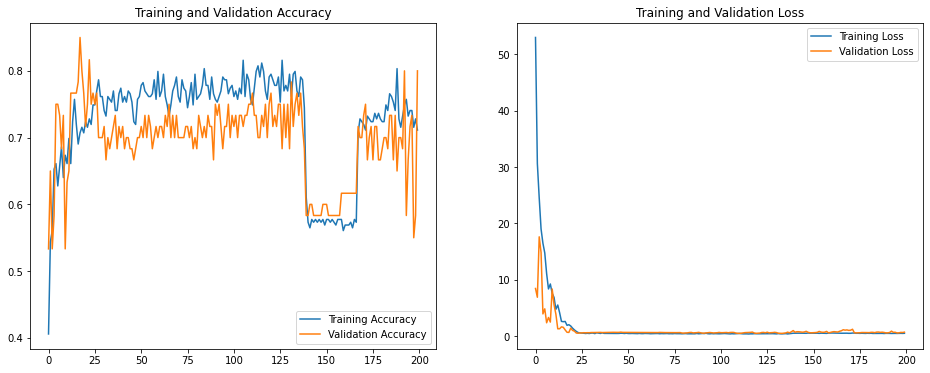

In [ ]:
acc = history_mfcc.history['accuracy']
val_acc = history_mfcc.history['val_accuracy']

loss = history_mfcc.history['loss']
val_loss = history_mfcc.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le modèle ne semble pas trop overfitté car la coubre de validation reste toujours proche de celle de train. L'accuracy semble stagnée.

In [ ]:
test_accuracy=mfcc_model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.800000011920929


Sources fusion

https://github.com/naity/image_tabular
https://github.com/naity/image_tabular/blob/master/siim_isic_integrated_model.ipynb#siim_isic_integrated

https://stackoverflow.com/questions/47035367/merge-two-different-deep-learning-models-in-keras

## Data fusion

On va maintenant essayer de fusionner les 2 modèles implémenté précedemment.

In [ ]:
y_train_full

,label
0,1
1,0
2,1
3,1
4,1
...,...
294,1
295,0
296,0
297,1


In [ ]:
y

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])

In [ ]:
from keras import Sequential, Model
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, concatenate
import numpy as np

# model1 = Sequential()
# model1.add(Embedding(20, 10, trainable=True))
# model1.add(GlobalAveragePooling1D())
# model1.add(Dense(1, activation='sigmoid'))

spect_model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=X_train_full[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(1, activation=keras.activations.sigmoid)
    ])

# model2 = Sequential()
# model2.add(Embedding(20, 10, trainable=True))
# model2.add(GlobalAveragePooling1D())
# model2.add(Dense(1, activation='sigmoid'))

mfcc_model=Sequential()
mfcc_model.add(Dense(26, activation="relu", input_shape = (26,)))  # input shape correspond to the shape[1] of X (nb of features)
mfcc_model.add(Dense(52, activation = "relu"))
mfcc_model.add(Dense(26, activation = "relu"))
mfcc_model.add(Dropout(0.1))
mfcc_model.add(Dense(1, activation = "sigmoid"))  # binary (audible / not audible)

model_concat = concatenate([spect_model.output, mfcc_model.output], axis=-1)
model_concat = Dense(1, activation='softmax')(model_concat)
new_model = Model(inputs=[spect_model.input, mfcc_model.input], outputs=model_concat)

new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

new_model.fit([X_train_full, X], y_train_full, epochs=200, # batch_size=1000,
              shuffle=True, validation_split=0.1, verbose=True)

Epoch 1/200
9/9 [==============================] - 4s 275ms/step - loss: 0.7005 - accuracy: 0.5688 - val_loss: 0.7157 - val_accuracy: 0.5333
Epoch 2/200
9/9 [==============================] - 2s 250ms/step - loss: 0.6964 - accuracy: 0.5688 - val_loss: 0.6971 - val_accuracy: 0.5333
Epoch 3/200
9/9 [==============================] - 2s 252ms/step - loss: 0.6870 - accuracy: 0.5688 - val_loss: 0.6944 - val_accuracy: 0.5333
Epoch 4/200
9/9 [==============================] - 2s 251ms/step - loss: 0.6837 - accuracy: 0.5688 - val_loss: 0.6946 - val_accuracy: 0.5333
Epoch 5/200
9/9 [==============================] - 2s 257ms/step - loss: 0.6823 - accuracy: 0.5688 - val_loss: 0.6954 - val_accuracy: 0.5333
Epoch 6/200
9/9 [==============================] - 2s 256ms/step - loss: 0.6846 - accuracy: 0.5688 - val_loss: 0.6629 - val_accuracy: 0.5333
Epoch 7/200
9/9 [==============================] - 2s 258ms/step - loss: 0.6693 - accuracy: 0.5688 - val_loss: 0.6636 - val_accuracy: 0.5333
Epoch 8/200
9

KeyboardInterrupt: ignored

Le modèle ne semble pas fonctionner. Ceci est une piste pour la suite du projet qu'il faudrait étudier plus en profondeur...